<a href="https://colab.research.google.com/github/dnf6541/ME592HW4_IMAGEANALYTICS1/blob/main/HW4_gwd_retinanet_pytorch_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ME 592 - RetinaNet in PyTorch - Global Wheat Detection 
# Image Analytics 1 - HW 4



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### Cloning Github Repository 
!git clone https://github.com/yhenon/pytorch-retinanet.git

Cloning into 'pytorch-retinanet'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 232 (delta 1), reused 1 (delta 0), pack-reused 226
Receiving objects: 100% (232/232), 1.02 MiB | 16.53 MiB/s, done.
Resolving deltas: 100% (116/116), done.


In [ ]:
### Copying RetinaNet Folder to root dir so we can import it easily
!cp -r pytorch-retinanet/retinanet ./

In [ ]:
!pip install pycocotools

In [ ]:
import os
import re
import cv2
import time
import numpy as np
import pandas as pd


import torch
import torch.optim as optim
import torchvision.transforms as T
from torchvision.utils import make_grid 
from torch.utils.data import DataLoader, Dataset

from retinanet import model
from retinanet.dataloader import collater, Resizer, Augmenter, Normalizer, UnNormalizer

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

DIR = "/content/drive/MyDrive/Homework4/Homework4/global-wheat-detection/"
DIR_TRAIN = DIR + "train"
DIR_TEST = DIR + "test"

# Exploring Dataset 📊

In [ ]:
### Loading Dataset
df = pd.read_csv(DIR + "train.csv")
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


Converting bbox list from original df to some appropriate form

In [ ]:
### Converting bbox list in appropriate form

df['x'] = -1
df['y'] = -1
df['w'] = -1
df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

df[['x', 'y', 'w', 'h']] = np.stack(df['bbox'].apply(lambda x: expand_bbox(x)))
df.drop(columns=['bbox'], inplace=True)
df['x'] = df['x'].astype(np.float)
df['y'] = df['y'].astype(np.float)
df['w'] = df['w'].astype(np.float)
df['h'] = df['h'].astype(np.float)

df.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


Null Values, Unique Images, etc.

In [ ]:
### Null Values, Unique Images, etc.

unq_values = df["image_id"].unique()
print("Total Records: ", len(df))
print("Unique Images: ",len(unq_values))

null_values = df.isnull().sum(axis = 0)
print("\n> Null Values in each column <")
print(null_values)



Total Records:  147793
Unique Images:  3373

> Null Values in each column <
image_id    0
width       0
height      0
source      0
x           0
y           0
w           0
h           0
dtype: int64


In [ ]:
### Data Sources

sources = df["source"].unique()
print("Total Sources: ",len(sources))
print("\n> Sources <\n",sources)

Total Sources:  7

> Sources <
 ['usask_1' 'arvalis_1' 'inrae_1' 'ethz_1' 'arvalis_3' 'rres_1' 'arvalis_2']


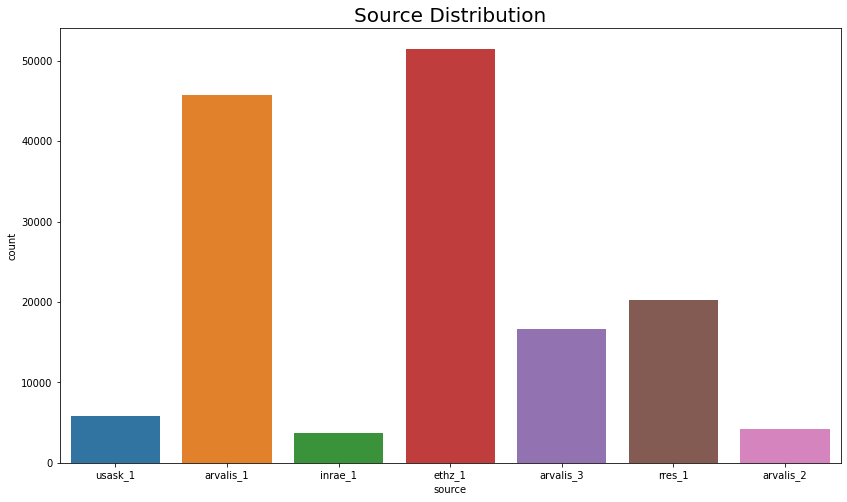

In [ ]:
### Visualizing Source Distribution

plt.figure(figsize=(14,8))
plt.title('Source Distribution', fontsize= 20)
sns.countplot(x = "source", data = df)

In [ ]:
### Splitting Train Dataset into train - val (80:20)

images = df['image_id'].unique()
valid_imgs = images[-674:]
train_imgs = images[:-674]

valid_df = df[df['image_id'].isin(valid_imgs)]
train_df = df[df['image_id'].isin(train_imgs)]


# Visualize Random Images with BBox 🕵️‍

In [ ]:
### Function to plot image

def plot_img(image_name):
    
    fig, ax = plt.subplots(1, 2, figsize = (10, 10))
    ax = ax.flatten()
    
    records = df[df['image_id'] == image_name]
    img_path = os.path.join(DIR_TRAIN, image_name + ".jpg")
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image
    
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    
    for idx, row in records.iterrows():
        box = row[['x', 'y', 'w', 'h']].values
        xmin = box[0]
        ymin = box[1]
        width = box[2]
        height = box[3]
        
        cv2.rectangle(image2, (int(xmin),int(ymin)), (int(xmin + width),int(ymin + height)), (255,0,0), 3)
    
    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


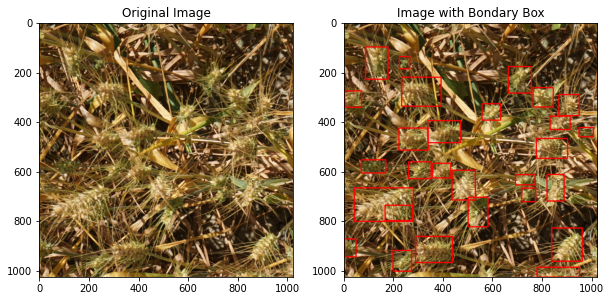

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


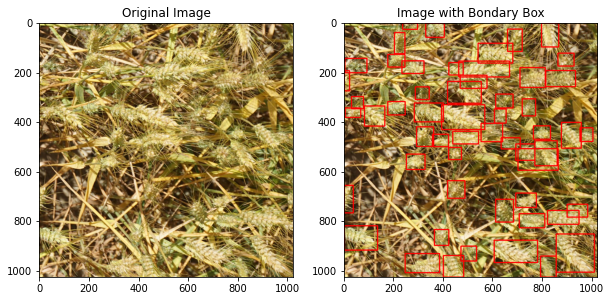

In [ ]:
### Pass any image id as parameter

plot_img("0126b7d11")
plot_img("00333207f")

# Preparing Dataset for Training 📂

In [ ]:
### Creating targets for model using Dataset Class

class GWD(Dataset):

    def __init__(self, dataframe, image_dir, mode = "train", transforms = None):
        
        super().__init__()
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.mode = mode
        self.transforms = transforms

    def __getitem__(self, index: int):

        # Retriving image id and records from df
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        # Loading Image
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        # If mode is set to train, then only we create targets
        if self.mode == "train" or self.mode == "valid":

            # Converting xmin, ymin, w, h to x1, y1, x2, y2
            boxes = np.zeros((records.shape[0], 5))
            boxes[:, 0:4] = records[['x', 'y', 'w', 'h']].values
            boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
            boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
            boxes[:, 4] = 1 # This is for label, as we have only 1 class, it is always 1
            
            # Applying Transforms
            sample = {'img': image, 'annot': boxes}
                
            if self.transforms:
                sample = self.transforms(sample)

            return sample
        
        elif self.mode == "test":
            
            # We just need to apply transoforms and return image
            if self.transforms:
                
                sample = {'img' : image}
                sample = self.transforms(sample)
                
            return sample
        

    def __len__(self) -> int:
        return self.image_ids.shape[0]
    

In [ ]:
### Preparing Datasets and Dataloaders for Training 

# Dataset Object
train_dataset = GWD(train_df, DIR_TRAIN, mode = "train", transforms = T.Compose([Augmenter(), Normalizer(), Resizer()]))
valid_dataset = GWD(valid_df, DIR_TRAIN, mode = "valid", transforms = T.Compose([Normalizer(), Resizer()]))

# DataLoaders
train_data_loader = DataLoader(
    train_dataset,
    batch_size = 8,
    shuffle = True,
    num_workers = 4,
    collate_fn = collater
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = 8,
    shuffle = True,
    num_workers = 4,
    collate_fn = collater
)


test_data_loader = DataLoader(
    valid_dataset,
    batch_size = 1,
    shuffle = True,
    num_workers = 4,
    collate_fn = collater
)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Create Model - RetinaNet 

In [ ]:
### Utilize GPU if available

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

In [ ]:
### We used Pre-trained Resnet34 as backbone because it showed the highest accuracy

retinanet = model.resnet34(num_classes = 2, pretrained = True)

# Loading Pre-trained model - if you load pre-trained model, comment above line.
#retinanet = torch.load("path_to_.pt_file")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to ./resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
### Preparing model for training

# Defininig Optimizer
optimizer = torch.optim.Adam(retinanet.parameters(), lr = 0.0001)

# Learning Rate Scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.5)

retinanet.to(device)

#No of epochs
epochs = 1


# Now comes everbody's favorite part 😋, let's train it!
I have defined functions to just improve the readability of the code, model and other parameters are defined outside.

In [ ]:
### One Epoch - Train

def train_one_epoch(epoch_num, train_data_loader):
    
    print("Epoch - {} Started".format(epoch_num))
    st = time.time()
    
    retinanet.train()
    
    epoch_loss = []

    for iter_num, data in enumerate(train_data_loader):
                
        # Reseting gradients after each iter
        optimizer.zero_grad()
            
        # Forward
        classification_loss, regression_loss = retinanet([data['img'].cuda().float(), data['annot'].cuda().float()])
                
        # Calculating Loss
        classification_loss = classification_loss.mean()
        regression_loss = regression_loss.mean()

        loss = classification_loss + regression_loss

        if bool(loss == 0):
            continue
                
        # Calculating Gradients
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(retinanet.parameters(), 0.1)
                
        # Updating Weights
        optimizer.step()

        #Epoch Loss
        epoch_loss.append(float(loss))

            
        print(
            'Epoch: {} | Iteration: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f}'.format(
                epoch_num, iter_num, float(classification_loss), float(regression_loss), np.mean(epoch_loss)))

        del classification_loss
        del regression_loss
        
    # Update the learning rate
    #if lr_scheduler is not None:
        #lr_scheduler.step()
        
    et = time.time()
    print("\n Total Time - {}\n".format(int(et - st)))
    
        

In [ ]:
### One Epoch - Valid

def valid_one_epoch(epoch_num, valid_data_loader):
    
    print("Epoch - {} Started".format(epoch_num))
    st = time.time()
    
    epoch_loss = []

    for iter_num, data in enumerate(valid_data_loader):
                
        with torch.no_grad():
            
            # Forward
            classification_loss, regression_loss = retinanet([data['img'].cuda().float(), data['annot'].cuda().float()])

            # Calculating Loss
            classification_loss = classification_loss.mean()
            regression_loss = regression_loss.mean()
            loss = classification_loss + regression_loss

            #Epoch Loss
            epoch_loss.append(float(loss))

            print(
                'Epoch: {} | Iteration: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f}'.format(
                    epoch_num, iter_num, float(classification_loss), float(regression_loss), np.mean(epoch_loss)))

            del classification_loss
            del regression_loss
        
    et = time.time()
    print("\n Total Time - {}\n".format(int(et - st)))
    
    # Save Model after each epoch
    torch.save(retinanet, "/content/drive/MyDrive/Homework4/Homework4/retinanet_gwd_18_1.pt")
    
        

In [ ]:
### Training Loop
for epoch in range(epochs):
    
    # Call train function
    train_one_epoch(epoch, train_data_loader)
    
    # Call valid function
    valid_one_epoch(epoch, valid_data_loader)


Epoch - 0 Started


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0 | Iteration: 0 | Classification loss: 1.12847 | Regression loss: 1.05842 | Running loss: 2.18689
Epoch: 0 | Iteration: 1 | Classification loss: 0.94619 | Regression loss: 1.01168 | Running loss: 2.07238
Epoch: 0 | Iteration: 2 | Classification loss: 0.63203 | Regression loss: 0.97218 | Running loss: 1.91632
Epoch: 0 | Iteration: 3 | Classification loss: 1.93637 | Regression loss: 0.96772 | Running loss: 2.16326
Epoch: 0 | Iteration: 4 | Classification loss: 1.55338 | Regression loss: 1.02131 | Running loss: 2.24555
Epoch: 0 | Iteration: 5 | Classification loss: 0.64107 | Regression loss: 1.01357 | Running loss: 2.14707
Epoch: 0 | Iteration: 6 | Classification loss: 0.61926 | Regression loss: 1.03310 | Running loss: 2.07639
Epoch: 0 | Iteration: 7 | Classification loss: 0.65636 | Regression loss: 1.01472 | Running loss: 2.02573
Epoch: 0 | Iteration: 8 | Classification loss: 0.58789 | Regression loss: 0.98169 | Running loss: 1.97505
Epoch: 0 | Iteration: 9 | Classification loss:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


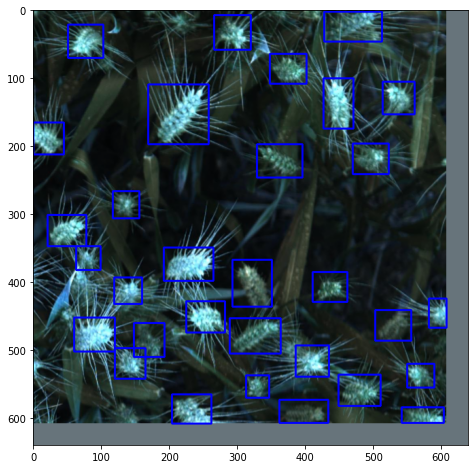

In [ ]:
### Sample Results
retinanet.eval()
unnormalize = UnNormalizer()

for iter_num, data in enumerate(test_data_loader):
    
    # Getting Predictions
    scores, classification, transformed_anchors = retinanet(data['img'].cuda().float())
    
    idxs = np.where(scores.cpu()>0.5)
    img = np.array(255 * unnormalize(data['img'][0, :, :, :])).copy()
    
    img[img<0] = 0
    img[img>255] = 255

    img = np.transpose(img, (1, 2, 0))

    img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    for j in range(idxs[0].shape[0]):
        bbox = transformed_anchors[idxs[0][j], :]
        x1 = int(bbox[0])
        y1 = int(bbox[1])
        x2 = int(bbox[2])
        y2 = int(bbox[3])

        cv2.rectangle(img, (x1, y1), (x2, y2), color = (0, 0, 255), thickness = 2)
        
    ax.imshow(img)
    
    break
    

We can see the model can draw appropriate bounding boxes and detect each wheat very well as you are able to see above an image.